In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from itertools import accumulate
import pickle
import numpy as np
from keras.utils import plot_model
# from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import re
import collections

In [2]:
# 设置matplotlib绘图时的字体
my_font = font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")

In [3]:
import sys
sys.path.append('/content/drive/My Drive/caplp-zhh')

In [4]:
%cd /content/drive/My Drive/caplp-zhh

/content/drive/My Drive/caplp-zhh


#### Load training dataset

In [5]:
df = pd.read_csv('training3.csv')

In [50]:
df.columns = list('abcdefghijk')

In [51]:
df = df.loc[:,['a','b','c','d','e','f']]

In [52]:
df.columns = ['label','id','time','query','acct','content']

In [53]:
df.head()

,label,id,time,query,acct,content
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [9]:
print(df.groupby('label')['label'].count())

label
0    799579
4    248996
Name: label, dtype: int64



分位点为0.91的句子长度:131.


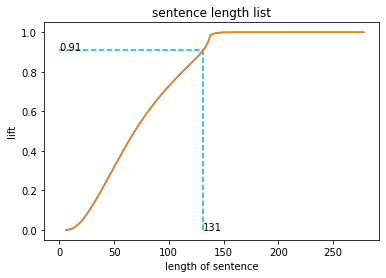

In [ ]:

df['length'] = df['content'].apply(lambda x: len(x))
len_df = df.groupby('length').count()
sent_length = len_df.index.tolist()
sent_freq = len_df['content'].tolist()

# 绘制句子长度及出现频数统计图
plt.bar(sent_length, sent_freq)
plt.xlabel("lenth of sentence")
plt.ylabel("frequency")
plt.savefig("./句子长度及出现频数统计图.png")
plt.close()

# 绘制句子长度累积分布函数(CDF)
sent_pentage_list = [(count/sum(sent_freq)) for count in accumulate(sent_freq)]

# 绘制CDF
plt.plot(sent_length, sent_pentage_list)

# 寻找分位点为quantile的句子长度
quantile = 0.91
#print(list(sent_pentage_list))
for length, per in zip(sent_length, sent_pentage_list):
    if round(per, 2) == quantile:
        index = length
        break
print("\n分位点为%s的句子长度:%d." % (quantile, index))

# 绘制句子长度累积分布函数图
plt.plot(sent_length, sent_pentage_list)
plt.hlines(quantile, 0, index, colors="c", linestyles="dashed")
plt.vlines(index, 0, quantile, colors="c", linestyles="dashed")
plt.text(0, quantile, str(quantile))
plt.text(index, 0, str(index))
plt.title("sentence length list",)
plt.xlabel("length of sentence",)
plt.ylabel("lift",)
plt.show()
plt.savefig("./句子长度累积分布函数图.png")
plt.close()

In [ ]:
#随机抽样到0.1 shuffle
df_sample = df.sample(frac=0.1).reset_index(drop=True)


In [ ]:
df_sample.to_csv(r'sample01.csv')

In [6]:
df_sample = pd.read_csv('sample01.csv')

In [ ]:
df_sample

,Unnamed: 0,label,id,time,query,acct,content
0,0,0,2218421980,Wed Jun 17 22:27:15 PDT 2009,NO_QUERY,DaniMarie16,@jesicka what happened to your youtube? all yo...
1,1,0,2002004723,Tue Jun 02 02:49:23 PDT 2009,NO_QUERY,ininininin,one more week before school.. one more week be...
2,2,0,2071239322,Sun Jun 07 19:04:07 PDT 2009,NO_QUERY,dillonross,"home for the night, knee is killing me"
3,3,0,1880705265,Fri May 22 02:12:08 PDT 2009,NO_QUERY,HannahDragonfly,i'm so sorry folks! my hp is temporarily block...
4,4,4,1469731007,Tue Apr 07 07:15:08 PDT 2009,NO_QUERY,magswallis,I have reluctantly cut back on the chocolate i...
...,...,...,...,...,...,...,...
104853,104853,0,1993915520,Mon Jun 01 11:07:37 PDT 2009,NO_QUERY,jasoncourt,E3: Oh no! the D'bag(sorry) from Epic is havin...
104854,104854,0,2051383177,Fri Jun 05 21:52:12 PDT 2009,NO_QUERY,JAGA,gots way too muches to do this weekend.
104855,104855,0,1793607358,Thu May 14 03:20:24 PDT 2009,NO_QUERY,cas04a,"And yes, I'm still awake. I really do miss my ..."
104856,104856,0,1998819906,Mon Jun 01 19:10:36 PDT 2009,NO_QUERY,Rissuhhh,"rented nick and norahs infinite playlist, but ..."


#### Dataset Preparation

In [7]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
df_sample.content = df_sample.content.apply(remove_stopwords).apply(remove_mentions)

In [10]:
print(df_sample.groupby('label')['label'].count())

label
0    80040
4    24818
Name: label, dtype: int64


In [11]:
import keras
from keras import models
from keras import layers
from keras import regularizers
import tensorflow as tf
print (keras.__version__)

2.4.3


In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
NB_WORDS = 30000  # Parameter indicating the number of words we'll put in the dictionary to create word vector
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_sample.content, df_sample.label, test_size=0.3, random_state=37,shuffle = True)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 73400
# Test data samples: 31458


In [15]:
y_train=[1 if i ==4 else i for i in y_train]
y_test = [1 if i ==4 else i for i in y_test]

####X_train go one-hot encodeing


In [ ]:
X_train[0]

'Ugh. HATE dentist. Stupid numb cheek/jaw eating dinner while.'

In [ ]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)


In [ ]:
print('"{}" is converted into {}'.format(X_train[4], X_train_seq[4]))

"Pretty much tomorrow going awesome! To-do list keeps growing never shrinks. oops-- care!" is converted into [1, 2, 3472, 302, 61, 391]


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
x_train_pad = pad_sequences(X_train_seq,maxlen = 140,padding='post')
X_test_pad = pad_sequences(X_test_seq,maxlen = 140,padding='post')

In [ ]:
x_train_pad[0]

array([40, 32,  1, 26,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)

In [ ]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

In [ ]:
X_train_oh = one_hot_seq(x_train_pad)
X_test_oh = one_hot_seq(X_test_pad)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[378, 464, 5722, 2372, 35, 55, 26, 209]" is converted into [1. 0. 0. ... 0. 0. 0.]
For this example we have 9.0 features with a value of 1.


In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print('"{}" is converted into {}'.format(y_train[1], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"0" is converted into 0
"0" is converted into [1. 0.]


In [ ]:
y_test_oh

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (2832, 10000)


In [ ]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history
base_history = deep_model(base_model)

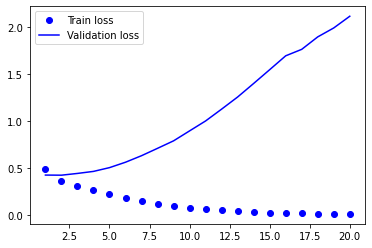

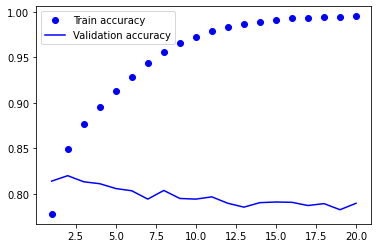

In [ ]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
eval_metric(base_history, 'loss')
eval_metric(base_history, 'accuracy')

In [ ]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'b', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'bo', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


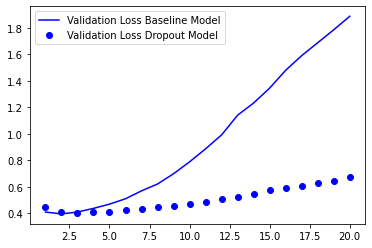

In [ ]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(2, activation='softmax'))
drop_model.summary()

drop_history = deep_model(drop_model)

compare_loss_with_baseline(drop_history, 'Dropout Model')

In [ ]:
# from gensim.models import word2vec

In [ ]:
# sentences = word2vec.Text8Corpus('text8')
# model = word2vec.Word2Vec(sentences, size=200)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


FileNotFoundError: ignored

In [ ]:

def create_LSTM(n_units, input_shape, output_dim, filepath):
    x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary = load_data(filepath)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim,
                        input_length=input_shape, mask_zero=True))
    model.add(LSTM(n_units, input_shape=(x.shape[0], x.shape[1])))
    model.add(Dropout(0.2))
    model.add(Dense(label_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    plot_model(model, to_file='./model_lstm.png', show_shapes=True)
    model.summary()

    return model


In [ ]:

# 模型训练
def model_train(input_shape, filepath, model_save_path):

    # 将数据集分为训练集和测试集，占比为7:3
    # input_shape = 100
    x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary = load_data(filepath, input_shape)
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 42)

    # 模型输入参数，需要自己根据需要调整
    n_units = 100
    batch_size = 32
    epochs = 5
    output_dim = 20

    # 模型训练
    lstm_model = create_LSTM(n_units, input_shape, output_dim, filepath)
    lstm_model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

    # 模型保存
    lstm_model.save(model_save_path)

    N = test_x.shape[0]  # 测试的条数
    predict = []
    label = []
    for start, end in zip(range(0, N, 1), range(1, N+1, 1)):
        sentence = [inverse_word_dictionary[i] for i in test_x[start] if i != 0]
        y_predict = lstm_model.predict(test_x[start:end])
        label_predict = output_dictionary[np.argmax(y_predict[0])]
        label_true = output_dictionary[np.argmax(test_y[start:end])]
        print(''.join(sentence), label_true, label_predict) # 输出预测结果
        predict.append(label_predict)
        label.append(label_true)

    acc = accuracy_score(predict, label) # 预测准确率
    print('模型在测试集上的准确率为: %s.' % acc)

if __name__ == '__main__':
    filepath = './corpus.csv'
    input_shape = 140
    model_save_path = './corpus_model.h5'
    model_train(input_shape, filepath, model_save_path)

#### X_train go tokenize and word2vec/glove





In [16]:
from nltk import word_tokenize, FreqDist
import string

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
def getToken(dataset):
  print('start')
  tokenlist = []
  for sentence in dataset:
    tokenlist.append(word_tokenize(sentence))
  return tokenlist

In [19]:
def removePunctuations(token_list):
  token_list_nop  = []
  for tokens in token_list:
    tokens_nop = [ t for t in tokens if t not in string.punctuation ]
    token_list_nop.append(tokens_nop)
  return token_list_nop

In [20]:
def remove_stopwords(token_list):
  token_list_nop  = []
  for tokens in token_list:
    tokens_nop = [ t for t in tokens if t not in ['...'] ]
    token_list_nop.append(tokens_nop)
  return token_list_nop

In [21]:
def Stemming(token_list):
  token_list_stm  = []
  porter = nltk.PorterStemmer()
  for tokens in token_list:
    tokens_porter=[ porter.stem(t) for t in tokens] 
    token_list_stm.append(tokens_porter)
  return token_list_stm

In [22]:
def tolowercase(token_list):
  token_list_stm  = []
  for tokens in token_list:
    tokens_lc = [token.lower() for token in tokens]
    token_list_stm.append(tokens_lc)
  return token_list_stm
  

In [23]:
#get token
X_train_tokens = getToken(X_train)
total_tokens = getToken(df_sample.content)
X_test_tokens = getToken(X_test)

start
start
start


In [24]:
#删除标点
X_train_tokens_nop = removePunctuations(X_train_tokens)
X_test_tokens_nop =  removePunctuations(X_test_tokens)

In [25]:
total_tokens_nop = removePunctuations(total_tokens)

In [26]:
#Stemming

X_test_token_stm = Stemming(X_test_tokens_nop)
X_train_token_stm = Stemming(X_train_tokens_nop)

In [27]:
total_tokens_stm = Stemming(total_tokens_nop)

In [28]:

X_test_token_stw = remove_stopwords(X_test_token_stm)
X_train_token_stw = remove_stopwords(X_train_token_stm)


In [29]:
total_tokens_stw = remove_stopwords(total_tokens_stm)

In [30]:
X_train_token_lc = tolowercase(X_train_token_stw)
X_test_token_lc = tolowercase(X_test_token_stw)
total_tokens_lc = tolowercase(total_tokens_stw)

In [31]:
len(X_test_token_lc)

31458

In [32]:
#Word2Vec
import gensim

In [33]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 2
W2V_EPOCH = 100
W2V_MIN_COUNT = 2

In [ ]:
# Train Word Embeddings and save
sentences = gensim.models.word2vec.Text8Corpus('text8')
vocab_size = 20000

In [4]:
# w2v_model.save('word2vecModel2.model')

In [34]:
model2vec = gensim.models.word2vec.Word2Vec.load('word2vecModel2.model')

In [ ]:
#Relationship between words
model2vec.most_similar(positive = ['woman','king'], negative = ['man'],topn=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.6591631770133972),
 ('empress', 0.5508263111114502),
 ('elizabeth', 0.5504189133644104),
 ('princess', 0.5498108863830566),
 ('pharaoh', 0.5492161512374878),
 ('throne', 0.5476378202438354),
 ('daughter', 0.5420958995819092),
 ('prince', 0.5382765531539917),
 ('consort', 0.5381449460983276),
 ('mary', 0.5359816551208496)]

In [ ]:
model2vec.most_similar('man')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.6656605005264282),
 ('girl', 0.5846552848815918),
 ('creature', 0.5664242506027222),
 ('person', 0.5170060396194458),
 ('bride', 0.5026669502258301),
 ('boy', 0.5024193525314331),
 ('gentleman', 0.5013751983642578),
 ('evil', 0.48922067880630493),
 ('demon', 0.4869570732116699),
 ('beast', 0.48051393032073975)]

In [35]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten

In [36]:
#Convert words to integers
tokenizer = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tokenizer.fit_on_texts(total_tokens_lc)
X_train = tokenizer.texts_to_sequences(X_train_token_lc)
X_test = tokenizer.texts_to_sequences(X_test_token_lc)


In [37]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 58509 unique tokens.


In [99]:
#glove
embeddings_index = {}
f = open('/content/drive/My Drive/caplp-zhh/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [100]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [38]:
#text8
embeddings_index = model2vec.wv
embedding_matrix = np.zeros((len(word_index) + 1, W2V_SIZE))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except KeyError:
        embedding_vector = 0
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(58510, 50)

In [39]:
#lenght of tweet to consider
maxlentweet = 140
#add padding
X_train = pad_sequences(X_train, maxlen=maxlentweet)
X_test = pad_sequences(X_test, maxlen=maxlentweet)


####LSTM Model


In [101]:
#create a embedding layer using pre triained word2vec 
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=50, weights=[embedding_matrix], 
                            input_length=maxlentweet)


In [102]:
#create model
lstm_out = 80

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=lstm_out))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model, to_file='./model_lstm.png', show_shapes=True)
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 140, 50)           2925500   
_________________________________________________________________
lstm_6 (LSTM)                (None, 80)                41920     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 81        
Total params: 2,967,501
Trainable params: 2,967,501
Non-trainable params: 0
_________________________________________________________________


In [80]:
dict_d = {}
for key in y_train:
    dict_d[key] = dict_d.get(key, 0) + 1
print(dict_d)

{0: 56072, 1: 17328}


In [81]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)


In [82]:
class_weights_d = dict(enumerate(class_weights))

In [83]:
from keras.callbacks import ModelCheckpoint

In [84]:
filepath="weights-improvement4-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
mode='min')
callbacks_list = [checkpoint]


In [68]:
batch_size = 32

In [103]:
#fit model00
#weights-improvement2-03-0.45----version 3
#weights-improvement-01-0.48
model.fit(X_train.tolist(), y_train, epochs=5, verbose=1, batch_size=batch_size, validation_data = (X_test.tolist(), y_test),class_weight=class_weights_d,callbacks=callbacks_list,)

Epoch 1/5
2293/2294 [============================>.] - ETA: 0s - loss: 0.5247 - accuracy: 0.7372
Epoch 00001: val_loss did not improve from 0.45039
2294/2294 [==============================] - 101s 44ms/step - loss: 0.5247 - accuracy: 0.7372 - val_loss: 0.4801 - val_accuracy: 0.7652
Epoch 2/5
2293/2294 [============================>.] - ETA: 0s - loss: 0.4320 - accuracy: 0.8009
Epoch 00002: val_loss improved from 0.45039 to 0.43290, saving model to weights-improvement4-02-0.43.hdf5
2294/2294 [==============================] - 84s 37ms/step - loss: 0.4319 - accuracy: 0.8009 - val_loss: 0.4329 - val_accuracy: 0.7962
Epoch 3/5
2294/2294 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8298
Epoch 00003: val_loss did not improve from 0.43290
2294/2294 [==============================] - 83s 36ms/step - loss: 0.3757 - accuracy: 0.8298 - val_loss: 0.4558 - val_accuracy: 0.7971
Epoch 4/5
2293/2294 [============================>.] - ETA: 0s - loss: 0.3291 - accuracy: 0.849

In [ ]:
model.save("lstm_model_4_07pc")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: lstm_model_4_07pc/assets


In [56]:
from keras.models import load_model

In [104]:
model = load_model('/content/drive/My Drive/caplp-zhh/weights-improvement4-02-0.43.hdf5')

In [3]:
#analyze the results
score, acc = model.evaluate(X_test.tolist(), y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)

In [106]:
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report

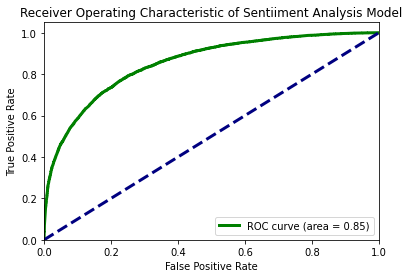

In [107]:

#ROC AUC curve
rocAuc = roc_auc_score(y_test, y_pred)

falsePositiveRate, truePositiveRate, _ = roc_curve(y_test, y_pred)

plt.figure()

plt.plot(falsePositiveRate, truePositiveRate, color='green',
         lw=3, label='ROC curve (area = %0.2f)' % rocAuc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiiment Analysis Model')
plt.legend(loc="lower right")
plt.show()

In [109]:
#Other accuracy metrices
y_pred = (y_pred > 0.5)

#confusion metrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

#F1 Score, Recall and Precision
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))



[[19695  4273]
 [ 2137  5353]]
              precision    recall  f1-score   support

    Negative       0.90      0.82      0.86     23968
    Positive       0.56      0.71      0.63      7490

    accuracy                           0.80     31458
   macro avg       0.73      0.77      0.74     31458
weighted avg       0.82      0.80      0.80     31458



#### Data Labeling on tweet dataset


In [ ]:
df_vaccine = pd.read_csv('vaccine.txt', header = None)


In [ ]:
#get token
df_vaccine_tokens = getToken(df_vaccine[0])

start


In [ ]:
df_vaccine_tokens_nop = removePunctuations(df_vaccine_tokens)

In [ ]:
df_vaccine_tokens_stm = Stemming(df_vaccine_tokens_nop)

In [ ]:
df_vaccine_stw = remove_stopwords(df_vaccine_tokens_stm)

In [ ]:
df_vaccine_lc = remove_stopwords(df_vaccine_stw)

In [ ]:
def convert2Val(total_tokens_lc,token_lc):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(total_tokens_lc)
  df_vaccine_val = tokenizer.texts_to_sequences(token_lc)
  #lenght of tweet to consider
  maxlentweet = 140
  #add padding
  df_vaccine_val = pad_sequences(df_vaccine_val, maxlen=maxlentweet)
  return df_vaccine_val

In [ ]:
df_vaccine_val = convert2Val(total_tokens_lc,df_vaccine_lc)

In [ ]:
len(df_vaccine_val[0])

140

In [ ]:
y_pred_sentilabel_vaccine = model.predict(df_vaccine_val)

In [ ]:
y_pred_sentilabel_vaccine_01 =  np.where(y_pred_sentilabel_vaccine > 0.5, 1, 0)

In [ ]:
a = y_pred_sentilabel_vaccine_01
dict = {}
for key in a:
    dict[key] = dict.get(key, 0) + 1
print (dict)

TypeError: ignored

In [ ]:
import numpy as np
import pandas as pd
prediction = pd.DataFrame(y_pred_sentilabel_vaccine_01, columns=['predictions']).to_csv('prediction_vacc4.csv')

In [ ]:
df_quarantine = pd.read_csv('quarantine.txt', header = None)
df_quarantine_tokens = getToken(df_quarantine[0])

start


In [ ]:
df_quarantine_tokens_nop = removePunctuations(df_quarantine_tokens)
df_quarantine_tokens_stm = Stemming(df_quarantine_tokens_nop)
df_quarantine_tokens_stw = remove_stopwords(df_quarantine_tokens_stm)
df_quarantine_tokens_lc = remove_stopwords(df_quarantine_tokens_stw)
df_quarantine_val = convert2Val(total_tokens_lc,df_quarantine_tokens_lc)

In [ ]:
y_pred_sentilabel_quarantine = model.predict(df_quarantine_val)
y_pred_sentilabel_quarantine_01 =  np.where(y_pred_sentilabel_quarantine > 0.5, 1, 0)


In [ ]:
prediction = pd.DataFrame(y_pred_sentilabel_quarantine_01, columns=['predictions']).to_csv('prediction_quar4.csv')

In [ ]:
df_economy = pd.read_csv('economy.txt', header = None)
df_economy_tokens = getToken(df_economy[0])
df_economy_tokens_nop = removePunctuations(df_economy_tokens)
df_economy_tokens_stm = Stemming(df_economy_tokens_nop)
df_economy_tokens_stw = remove_stopwords(df_economy_tokens_stm)
df_economy_tokens_lc = remove_stopwords(df_economy_tokens_stw)
df_economy_val = convert2Val(total_tokens_lc,df_economy_tokens_lc)

start


In [ ]:
y_pred_sentilabel_economy = model.predict(df_economy_val)
y_pred_sentilabel_economy_01 =  np.where(y_pred_sentilabel_economy > 0.5, 1, 0)
prediction = pd.DataFrame(y_pred_sentilabel_economy_01, columns=['predictions']).to_csv('prediction_eco4.csv')

In [ ]:
df_economy[0][90]

0        Over 200 000 deaths from COVID 19 because of y...
1        me2 You re literally arguing that you can forc...
2        When the Dow has a bad day that s when the lef...
3        The latest COVID 19 information for Douglas Co...
4        Twitter Again Accuses Trump Of COVID 19 Misinf...
                               ...                        
61849    KNL Knoll Inc KNL CEO Andrew Cogan on Q3 2020 ...
61850    3rd LD S Korea s economy returns to growth in ...
61851    VOTE THE UGLY ASS REPUBLICANS out SC and Kentucky
61852    my grandpa DESPISES Trump and says the only re...
61853    Markets have their worst day in a month on Cov...
Name: 0, Length: 61854, dtype: object

In [ ]:
y_pred_sentilabel_quarantine_01

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
a = y_pred_sentilabel_economy_01
dict = {}
for key in a:
    dict[key] = dict.get(key, 0) + 1
print (dict)

NameError: ignored